{'Rotation': 0.0, 'Particles': 1000}


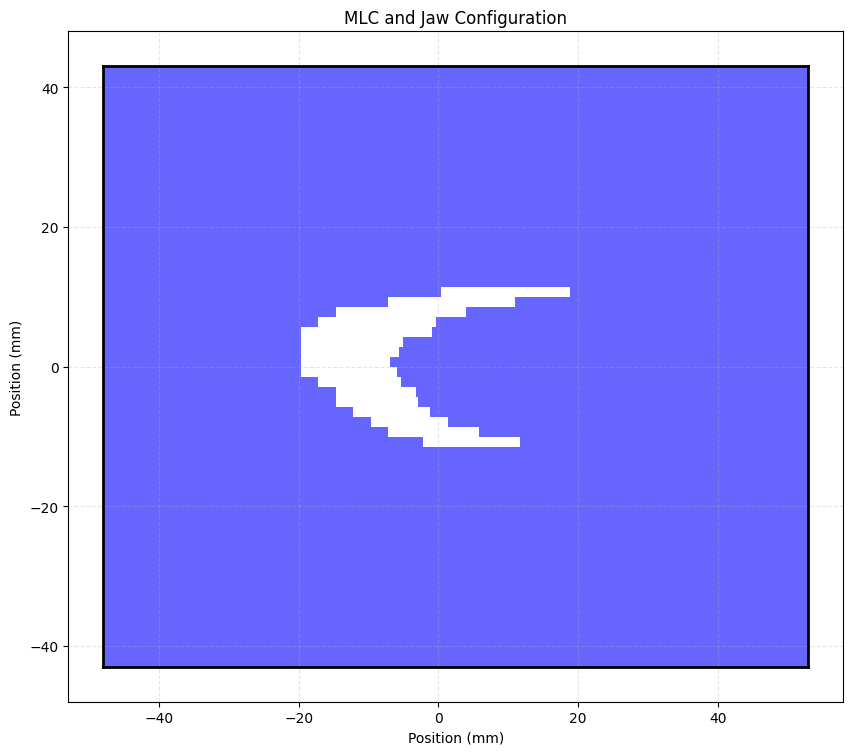

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file = "1. prostate_imrt_beam0_cp0.dat"

def parse_mlc_data():
    with open(file) as fp:
      data = fp.read()
    lines = data.strip().split('\n')
    
    # read data from comments
    comments = [line for line in lines if line.startswith('#')]
    comment_params = {}
    for comment in comments:
        key = comment.removeprefix("# ").rstrip("0123456789. :")
        value = comment.removeprefix('# ').split(" ", 1)[1]
        if '.' in value:
            try:
                value = float(value)
            except ValueError:
                continue
        else:
            try:
                value = int(value)
            except ValueError:
                continue
        comment_params[key] = value
    
    # remove comments, no longer needed
    lines = [line for line in lines if not line.startswith("#")]
    
    # Parse jaws data
    jaws = map(float, lines[0].split(','))
    
    # Parse MLC positions
    mlc_positions = []
    for line in lines[1:]:
        if ',' in line:
            left, right = map(float, line.split(','))
            mlc_positions.append((left, right))
    
    return jaws, np.array(mlc_positions), comment_params

def plot_mlc_configuration():
    # Parse data
    (X1, X2, Y1, Y2), mlc_positions, comment_params = parse_mlc_data()
    print(comment_params)
    
    # Create figure
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    # Calculate leaf heights
    n_leaves = len(mlc_positions)
    leaf_heights = np.linspace(Y1, Y2, n_leaves + 1)
    leaf_height = (Y2 - Y1) / n_leaves # width of rectangles
    
    # Plot each MLC leaf pair
    # data is arranged bottom-up
    for i, (left, right) in enumerate(mlc_positions):
        y_pos = leaf_heights[i]

        # plot rectangles

        # (X1, y_pos + leaf_height)-----(left, ypos + leaf_height)
        # |                                       |
        # (X1, y_pos)-------------------(left, y_pos)
        plt.fill([X1, left, left, X1],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
        
        # (right, y_pos + leaf_height)-----(X2, ypos + leaf_height)
        # |                                       |
        # (right, y_pos)-------------------(X2, y_pos)
        plt.fill([right, X2, X2, right],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
    
    # Plot jaw boundaries
    plt.plot([X1, X1], [Y1, Y2], 'k-', linewidth=2)  # Left jaw
    plt.plot([X2, X2], [Y1, Y2], 'k-', linewidth=2)  # Right jaw
    plt.plot([X1, X2], [Y1, Y1], 'k-', linewidth=2)  # Bottom jaw
    plt.plot([X1, X2], [Y2, Y2], 'k-', linewidth=2)  # Top jaw
    
    # Set plot properties
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')
    plt.title('MLC and Jaw Configuration')
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    plt.xlim(X1 - 5, X2 + 5)
    plt.ylim(Y1 - 5, Y2 + 5)
    
    return plt.gcf()

# Create and display the plot
fig = plot_mlc_configuration()
plt.show()

    Cell IdX  Cell IdY  Cell IdZ  X [mm]  Y [mm]  Z [mm]      Dose  \
18         0         0         0     -18     -18       6  0.000097   
25         0         0         1     -18     -18      18  0.000201   
31         0         1         0     -18      -6       6  0.002524   
0          0         1         1     -18      -6      18  0.003416   
17         0         2         0     -18       6       6  0.005445   
14         0         2         1     -18       6      18  0.006825   
23         0         3         0     -18      18       6  0.000427   
30         0         3         1     -18      18      18  0.000737   
10         1         0         0      -6     -18       6  0.003053   
2          1         0         1      -6     -18      18  0.003953   
7          1         1         0      -6      -6       6  0.005773   
24         1         1         1      -6      -6      18  0.006948   
29         1         2         0      -6       6       6  0.005624   
11         1        

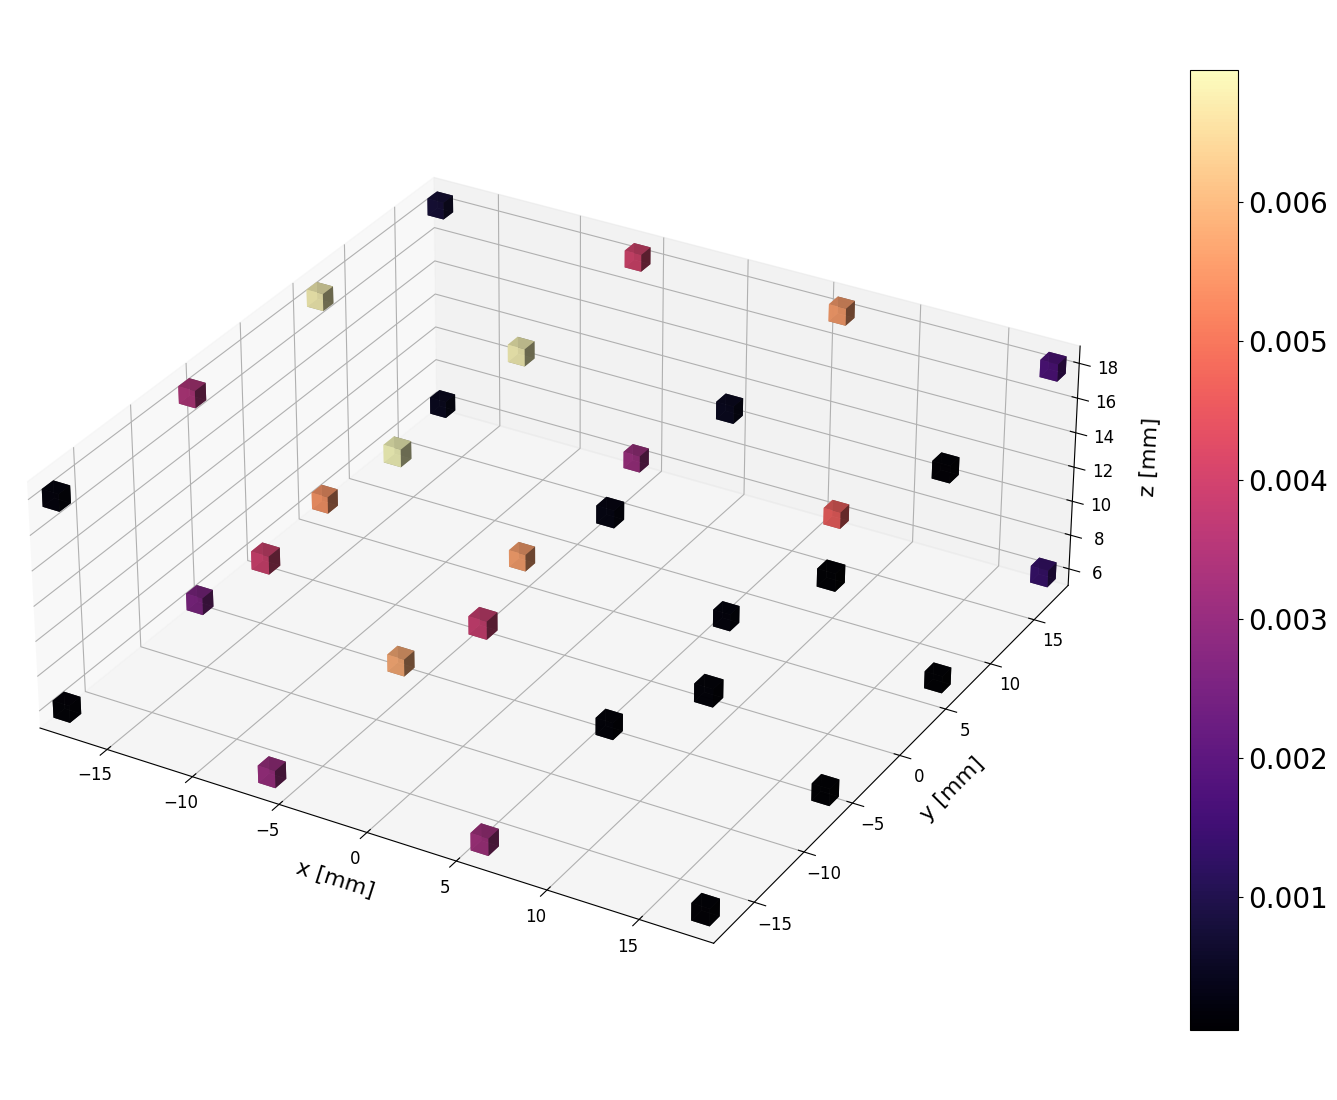

In [2]:
import pandas as pd
import polars as pl
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

counter=0

def add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, min, max):
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

  global counter
  print(f"adding {counter} voxel...")
  counter+=1
  
  # phantom_counts_norm = colors.LogNorm(vmin=min, vmax=max)
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)


if __name__ == "__main__":
  filename = "cp-0_d3ddetector_cell.csv"
  raw_df = pd.read_csv(filename)

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  voxel_side_len = 0.985
  observable = "Dose"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')
  
  df = sorted_df
  print(df)

  dose_max = df[observable].max()
  dose_min = df[df[observable]>0][observable].min()
  
  for _, row in df.iterrows():
      if row[observable] == 0:
          print(f"skipping row {row}")
          continue
      x_center = row['X [mm]']
      y_center = row['Y [mm]']
      z_center = row['Z [mm]']

      dose = row[observable]
      add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)

  # Ustawienie limitów osi
  x_min, x_max = df['X [mm]'].min() - voxel_side_len, df['X [mm]'].max() + voxel_side_len
  y_min, y_max = df['Y [mm]'].min() - voxel_side_len, df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = df['Z [mm]'].min() - voxel_side_len, df['Z [mm]'].max() + voxel_side_len

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()


adding 0/864 voxel...
adding 1/864 voxel...
adding 2/864 voxel...
adding 3/864 voxel...
adding 4/864 voxel...
adding 5/864 voxel...
adding 6/864 voxel...
adding 7/864 voxel...
adding 8/864 voxel...
adding 9/864 voxel...
adding 10/864 voxel...
adding 11/864 voxel...
adding 12/864 voxel...
adding 13/864 voxel...
adding 14/864 voxel...
adding 15/864 voxel...
adding 16/864 voxel...
adding 17/864 voxel...
adding 18/864 voxel...
adding 19/864 voxel...
adding 20/864 voxel...
adding 21/864 voxel...
adding 22/864 voxel...
adding 23/864 voxel...
adding 24/864 voxel...
adding 25/864 voxel...
adding 26/864 voxel...
adding 27/864 voxel...
adding 28/864 voxel...
adding 29/864 voxel...
adding 30/864 voxel...
adding 31/864 voxel...
adding 32/864 voxel...
adding 33/864 voxel...
adding 34/864 voxel...
adding 35/864 voxel...
adding 36/864 voxel...
adding 37/864 voxel...
adding 38/864 voxel...
adding 39/864 voxel...
adding 40/864 voxel...
adding 41/864 voxel...
adding 42/864 voxel...
adding 43/864 voxel..

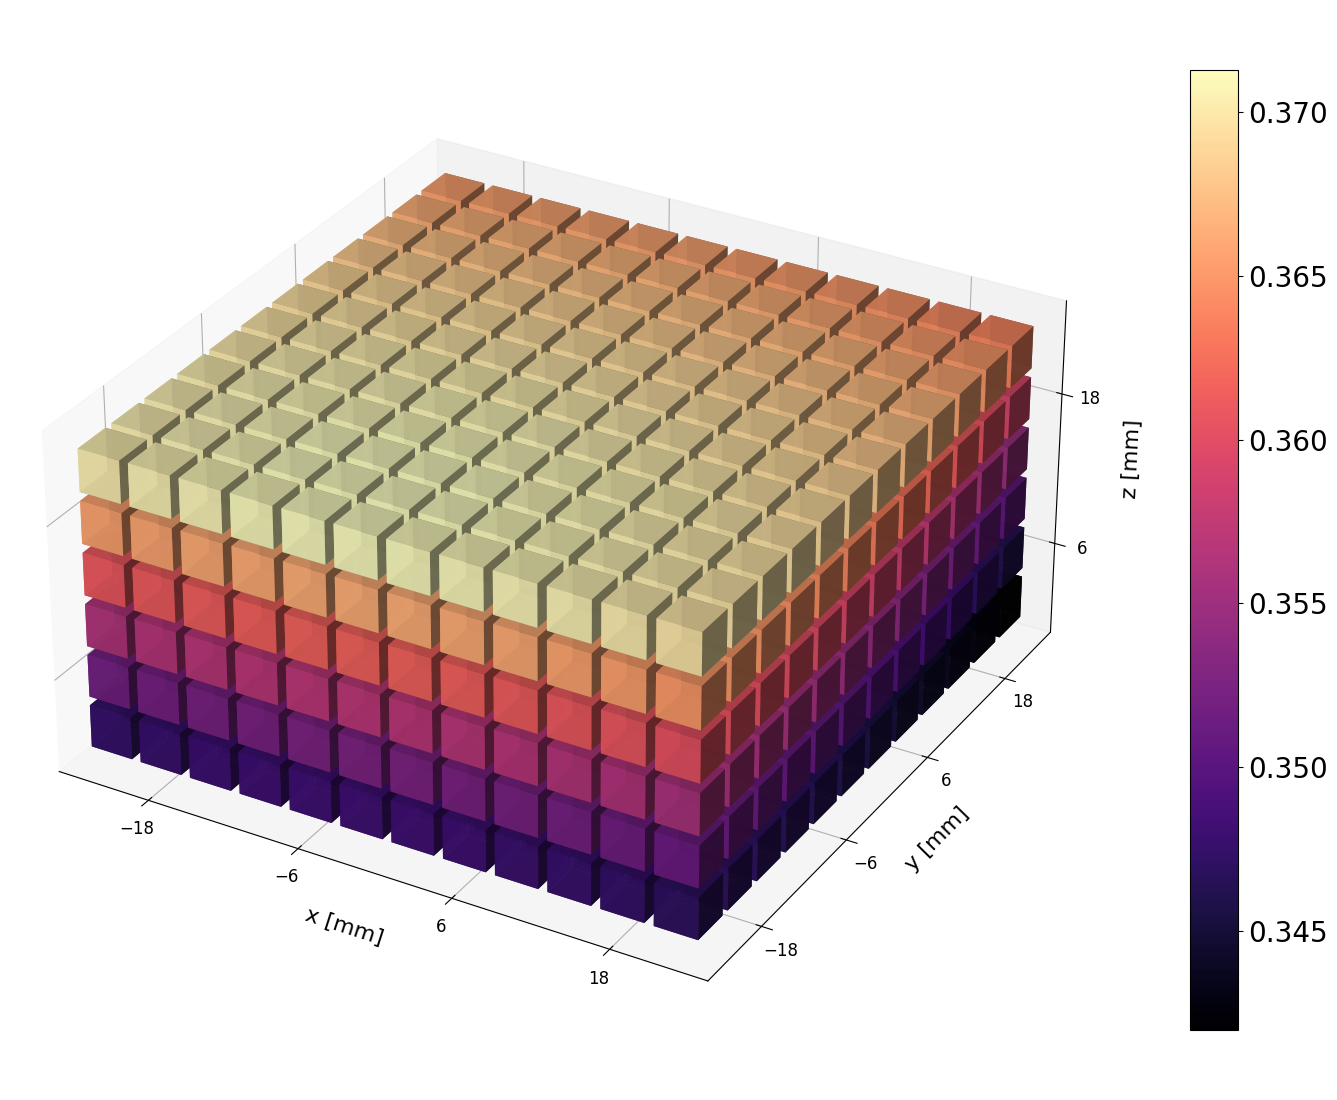

In [ ]:
import pandas as pd
import polars as pl
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from typing import Tuple, Union

def add_voxel(ax, x_center: float, y_center: float, z_center: float, voxel_side_len: float, dose: float, min: float, max: float) -> None:
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)

def enrich_df(input_df: pd.DataFrame, jaws: np.ndarray, mlc_positions: np.ndarray, factor: int=2) -> pd.DataFrame:
  offset = factor/(2*factor+1)
  unique_xs = sorted(input_df['X [mm]'].unique())
  unique_ys = sorted(input_df['Y [mm]'].unique())
  unique_zs = sorted(input_df['Z [mm]'].unique())
  # print(f"unique_xs: {unique_xs}")
  # print(f"unique_ys: {unique_ys}")
  # print(f"unique_zs: {unique_zs}")
  try:
    distance_x = np.abs(unique_xs[0] - unique_xs[1])
  except IndexError:
    distance_x = 5
  try:
    distance_y = np.abs(unique_ys[0] - unique_ys[1])
  except IndexError:
    distance_y = 5
  try:
    distance_z = np.abs(unique_zs[0] - unique_zs[1])
  except IndexError:
    distance_z = 5
  # print(f"unique_xs: {unique_xs}, distance_x: {distance_x}")
  # print(f"unique_ys: {unique_ys}, distance_y: {distance_y}")
  # print(f"unique_xs: {unique_zs}, distance_z: {distance_z}")
  to_insert = []
  x_len = len(unique_xs) * 2*factor+1
  y_len = len(unique_ys) * 2*factor+1
  z_len = len(unique_zs) * 2*factor+1
  for _, row in input_df.iterrows():
    try:
      dose = row["Dose"]
    except Exception:
      dose = row["Dose [Gy]"]
    # print(f"center in {row['X [mm]']}, {row['Y [mm]']}, {row['Z [mm]']}")
    # print(f"xs: {np.linspace(row["X [mm]"]-(distance_x*offset), row["X [mm]"]+(distance_x*offset), 2*factor+1)}")
    # print(f"ys: {np.linspace(row["Y [mm]"]-(distance_y*offset), row["Y [mm]"]+(distance_y*offset), 2*factor+1)}")
    # print(f"zs: {np.linspace(row["Z [mm]"]-(distance_z*offset), row["Z [mm]"]+(distance_z*offset), 2*factor+1)}")
    for x in np.linspace(row["X [mm]"]-(distance_x*offset), row["X [mm]"]+(distance_x*offset), 2*factor+1):
      for y in np.linspace(row["Y [mm]"]-(distance_y*offset), row["Y [mm]"]+(distance_y*offset), 2*factor+1):
        for z in np.linspace(row["Z [mm]"]-(distance_z*offset), row["Z [mm]"]+(distance_z*offset), 2*factor+1):
          to_insert.append({
              "Cell IdX": -1,
              "Cell IdY": -1,
              "Cell IdZ": -1,
              "X [mm]": x,
              "Y [mm]": y,
              "Z [mm]": z,
              "Dose": dose,
              "FieldScalingFactor": calculate_fsf(x, y, z, x_len, y_len, z_len, jaws, mlc_positions)
          })
  reindexed_df = reindex_df(pd.DataFrame(to_insert))
  return reindexed_df

def reindex_df(df: pd.DataFrame) -> pd.DataFrame:
  unique_xs = sorted(df['X [mm]'].unique())
  unique_ys = sorted(df['Y [mm]'].unique())
  unique_zs = sorted(df['Z [mm]'].unique())
  # print(f"unique_xs: {unique_xs}")
  # print(f"unique_ys: {unique_ys}")
  # print(f"unique_zs: {unique_zs}")
  for x_index, x in enumerate(unique_xs):
    for y_index, y in enumerate(unique_ys):
      for z_index, z in enumerate(unique_zs):
        mask = (df["X [mm]"] == x) & (df["Y [mm]"] == y) & (df["Z [mm]"] == z)
        df.loc[mask, 'Cell IdX'] = x_index
        df.loc[mask, 'Cell IdY'] = y_index
        df.loc[mask, 'Cell IdZ'] = z_index
  return df

def parse_mlc_data(filename: str) -> Tuple[np.ndarray, np.ndarray, dict[str, Union[float, int]]]:
    with open(filename) as fp:
      data = fp.read()
    lines = data.strip().split('\n')
    
    # read data from comments
    comments = [line for line in lines if line.startswith('#')]
    comment_params = {}
    for comment in comments:
      key = comment.removeprefix("# ").rstrip("0123456789. :")
      value = comment.removeprefix('# ').split(" ", 1)[1]
      if '.' in value:
        try:
          value = float(value)
        except ValueError:
          continue
      else:
        try:
          value = int(value)
        except ValueError:
          continue
      comment_params[key] = value
    
    # remove comments, no longer needed
    lines = [line for line in lines if not line.startswith("#")]
    
    # Parse jaws data
    jaws = np.array(list(map(float, lines[0].split(','))))
    
    # Parse MLC positions
    mlc_positions = []
    for line in lines[1:]:
      if ',' in line:
        left, right = map(float, line.split(','))
        mlc_positions.append((left, right))
    
    return jaws, np.array(mlc_positions), comment_params

def calculate_fsf(x: np.float64, y: np.float64, z: np.float64, nx: int, ny: int, nz: int, jaws: np.ndarray, mlc_positions: np.ndarray) -> np.float64:
  """
  Assumptions: 
  - MLC_leaf positions are calculated as (x_leaf, y_leaf+leaf_height/2, mlc_detector_distance)
  - angles are calculated in radians (0, np.pi)
  - closed jaws are skipped
  - y1MLC == y2MLC (???)
  - detector_distance is positive
  """
  *_, Y1, Y2 = jaws
  n_leaves = len(mlc_positions)
  leaf_height = (Y2 - Y1) / n_leaves
  mlc_detector_distance = 340
  mlc_centre = np.array((0, 0, mlc_detector_distance))

  y1MLC = 0
  y2MLC = 0

  current_y = Y1 + leaf_height/2
  for x_left, x_right in mlc_positions:
    if x_left == x_right: # skip closed jaws
      continue
    r_mlc = mlc_centre - np.array((x, y, z))

    r_leaf_left = (mlc_centre + np.array((x_left, current_y, 0))) - np.array((x, y, z))
    r_leaf_right= (mlc_centre + np.array((x_right, current_y, 0))) - np.array((x, y, z))
    # print(f"for x_left={x_left}, x_right={x_right}")
    # print(f"and x={x}, y={y}, z={z}")
    # print(f"r_leaf_left={r_leaf_left}")
    # print(f"r_leaf_right={r_leaf_right}")

    lambda_leaf_left = angle_between(r_mlc, r_leaf_left)
    lambda_leaf_right = angle_between(r_mlc, r_leaf_right)
    # print(f"lambda_leaf_left: {lambda_leaf_left}")
    # print(f"lambda_leaf_right: {lambda_leaf_right}")

    y1MLC += lambda_leaf_left + lambda_leaf_right
    y2MLC += lambda_leaf_left + lambda_leaf_right

    current_y += leaf_height
  fsf = y1MLC + y2MLC
  # nx = 4
  # ny = 4
  # nz = 2
  fsf_norm = fsf/(1*nx + 2*ny + 3*nz)
  min_scaling = 0.02
  max_scaling = 0.98
  fsf_minmax_norm = (fsf_norm - min_scaling)/(max_scaling - min_scaling)
  return fsf_minmax_norm

def angle_between(v1: np.ndarray, v2: np.ndarray) -> np.float64:
    """ Returns the angle in radians between vectors v1 and v2"""
    v1_len = np.sqrt(v1[0]**2 + v1[1]**2 + v1[2]**2)
    v2_len = np.sqrt(v2[0]**2 + v2[1]**2 + v2[2]**2)
    return np.arccos(np.dot(v1, v2)/(v1_len*v2_len))

def plot_df(df: pd.DataFrame, ticks_x: np.ndarray, ticks_y: np.ndarray, ticks_z: np.ndarray) -> None:
  voxel_side_len = sorted(df['X [mm]'].unique())[1] - sorted(df['X [mm]'].unique())[0] - 0.7
  observable = "FieldScalingFactor"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')

  dose_max = df[observable].max()
  dose_min = df[df[observable]>0][observable].min()

  counter=0
  max_voxel=len(df)
  for _, row in df.iterrows():
    if row[observable] == 0:
      print(f"skipping row {row}")
      continue
    x_center = row['X [mm]']
    y_center = row['Y [mm]']
    z_center = row['Z [mm]']

    dose = row[observable]
    print(f"adding {counter}/{max_voxel} voxel...")
    counter+=1

    add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)
  # Ustawienie limitów osi
  x_min, x_max = df['X [mm]'].min() - voxel_side_len, df['X [mm]'].max() + voxel_side_len
  y_min, y_max = df['Y [mm]'].min() - voxel_side_len, df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = df['Z [mm]'].min() - voxel_side_len, df['Z [mm]'].max() + voxel_side_len

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.set_xticks(ticks_x)
  ax.set_yticks(ticks_y)
  ax.set_zticks(ticks_z)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()

if __name__ == "__main__":
  data_filename = "cp-0_d3ddetector_cell.csv"
  # data_filename = "img0001.csv"
  raw_df = pd.read_csv(data_filename)

  mlc_filename = "1. prostate_imrt_beam0_cp0.dat"
  jaws, mlc_positions, _ = parse_mlc_data(mlc_filename)
  unique_xs_raw = np.array(sorted(raw_df['X [mm]'].unique()))
  unique_ys_raw = np.array(sorted(raw_df['Y [mm]'].unique()))
  unique_zs_raw = np.array(sorted(raw_df['Z [mm]'].unique()))

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  df = enrich_df(sorted_df, jaws, mlc_positions, 1)

  df.to_csv("output.csv")
  plot_df(df, unique_xs_raw, unique_ys_raw, unique_zs_raw)


# TODO: hardcode patient cell material
# TODO edit cp-0 Dose -> Dose [Gy]
# TODO target rozdzielczość to 1mm, factor do zmiany
# TODO target to 64mm na 64mm i w środku są kostki, reszta to powietrze
# TODO układ jak w slajdzie, wzrost z w sze